The sensitivity matrix of the equivalent layer linear system for magnetic data is given by:

$A = cte \, \hat{F}^T \, H \, \hat{h} $

where: $\hat{F}^T = [cos(I) cos(D) \quad cos(I)sen(D) \quad sen(I)] \,$ is the cosine directions of the main magnetic field and

$\hat{h} =\begin{bmatrix}
	cos(i) cos(d)\\
	cos(i)sen(d)\\ 
	sen(i)
	\end{bmatrix}\,$ is the cosine directions of the equivalent sources magnetizations.

$H = \pmatrix{H^{xx} & H^{xy} & H^{xz} \\ H^{xy} & H^{yy} & H^{yz} \\ H^{xz} & H^{yz} & H^{zz}}$

$H^{xx}$: Symmetric (symmetric BT - symmetric TB)

$H^{xy}$: Symmetric (skew symmetric BT - skew symmetric TB)

$H^{xz}$: Skew-symmetric (skew symmetric BT - symmetric TB)

$H^{yy}$: Symmetric (symmetric BT - symmetric TB)

$H^{yz}$: Skew-symmetric (symmetric BT - skew symmetric TB)

$H^{zz}$: Symmetric (symmetric BT - symmetric TB)

$A$: in general Nonsymmetric (nonsymmetric BT - nonsymmetric TB)

Symmetric BTTB and skew symmetric BTTB matrices can be entirely described by theirs first row or first column.

If we consider that $cte$, $F^T$ and $\hat{h}$ are constants that are multiplying the second derivatives of the harmonic funtion $1/r$, the sensibility matrix $A$ is purely the sum of the components $H_{xx} + H_{xy} + H_{xz} + H_{xy} + H_{yy} + H_{yz} + H_{xz} + H_{yz} + H_{zz}$ multiplied by the respectives constants of each component.

Thus, despite $A$ be neither symmetric BTTB matrix or skew-symmetric, it can be in fact, written by calculating only the first row or column of these components.

Taking advantage that any BTTB matrix can be transformed into a BCCB matrix and any BCCB matrix can be diagonalized using only its first column, it is possible to say that physically, only the effect of $1$ equivalent source is necessary to estimate the whole set of equivalent sources within the equivalent layer.

At the same time, taking in account that the BTTB matrix for magnetic data is a nonsymmetric BTTB, another way to calculate the first column of the BCCB matrix is to calculate the effect of the 4 sources at the edge of the equivalent layer (the first and last columns or rows of the first and the last columns or rows of blocks in the BTTB matrix).

At least for the algorithm that I was able to pull it off, the last is more computational efficient for fewer data (less than 150 000 observation points) and less memory dependent, but loses the property or "physical comprehension" of $1$ equivalent source usage.

## Import

In [4]:
import numpy as np
import sys
from matplotlib import pyplot as plt
from numpy.linalg import inv, norm
from scipy.optimize import curve_fit
import pickle as pickle
from sys import getsizeof
import gzip
import bz2
from timeit import default_timer as time
import functions_eq_mag as fc
import functions_fatiando as ft
%matplotlib inline

## Load pickle data

In [ ]:
with open('time_1vs4_sources.pickle', 'rb') as r:
    time_sources = pickle.load(r)

### Observation and Equivalent layer grids

In [5]:
# Create a regular grid at 0m height
area = [1, 4, 1, 6]
#area = [-5000., 5000., -4000., 4000.]
#shape = (50, 50)
shape = (4, 3)
xi, yi, zi = ft.gridder_regular(area, shape, z=0.)

# Equivalent Layer
areaj = [1, 4, 1, 6]
#areaj = [-5000., 5000., -4000., 4000.]
#shapej = (50, 50)
shapej = (4, 3)
xj, yj, zj = ft.gridder_regular(areaj, shapej, z=900.)

N = shape[0]*shape[1]
M = shapej[0]*shapej[1]

### Magnetic configuration

In [6]:
# Magnetic Configuration
inc0 = np.deg2rad(-30.)
dec0 = np.deg2rad(40.)
inc = np.deg2rad(25.)
dec = np.deg2rad(76.)
F = np.array([np.cos(inc0)*np.cos(dec0), np.cos(inc0)*np.sin(dec0), np.sin(inc0)])
h = np.array([np.cos(inc)*np.cos(dec), np.cos(inc)*np.sin(dec), np.sin(inc)])

# Sensitivity Matrix Toeplitz Construction To BCCB first column

### 1 source

In [15]:
s = time()

Hxx,Hxy,Hxz,Hyy,Hyz,Hzz = fc.h_bttb_mag(xi,yi,zi,zj,F,h,shape)
cev_mag_1 = fc.ones_cev_mag(Hxx,Hxy,Hxz,Hyy,Hyz,Hzz,shape,N,F,h)

e = time()
tcpu = e - s
print (tcpu)

0.0015215999997053586


### 4 edge sources

In [16]:
s = time()

bttb_0, bttb_1, bttb_2, bttb_3 = fc.bttb_mag(xi,yi,zi,zj,F,h,shape)
cev_mag_4 = fc.cev_mag(bttb_0,bttb_1,bttb_2,bttb_3,shape,N)

e = time()
tcpu = e - s
print (tcpu)

0.0009454000000914675


In [11]:
np.allclose(cev_mag_1, cev_mag_4, atol=1e-15)

True

### BTTB transposed (necessary during CGLS method)

### 1 source

In [12]:
s = time()

Hxx,Hxy,Hxz,Hyy,Hyz,Hzz = fc.h_bttb_mag(xi,yi,zi,zj,F,h,shape)
cev_mag_row_1 = fc.ones_cev_mag_row(Hxx,Hxy,Hxz,Hyy,Hyz,Hzz,shape,N,F,h)

e = time()
tcpu = e - s
print (tcpu)

0.001455300000088755


### 4 edge sources

In [13]:
s = time()

bttb_0, bttb_1, bttb_2, bttb_3 = fc.bttb_mag(xi,yi,zi,zj,F,h,shape)
cev_mag_row_4 = fc.cev_mag_row(bttb_0,bttb_1,bttb_2,bttb_3,shape,N)

e = time()
tcpu = e - s
print (tcpu)

0.0012058999996042985


In [14]:
np.allclose(cev_mag_row_1, cev_mag_row_4, atol=1e-15)

True

## Time comparison between 1 source vs. 4 sources

### 1 source

In [28]:
area = [-100, 100, -100, 100]
shape_list = []
temp_1 = []
for i in range(30):
    shape = (100+i*25, 100+i*25)
    xi, yi, zi = ft.gridder_regular(area, shape, z=0.)
    xj, yj, zj = ft.gridder_regular(area, shape, z=900.)

    N = shape[0]*shape[1]
    
    s = time()
    Hxx,Hxy,Hxz,Hyy,Hyz,Hzz = fc.h_bttb_mag(xi,yi,zi,zj,F,h,shape)
    cev_mag_1 = fc.ones_cev_mag(Hxx,Hxy,Hxz,Hyy,Hyz,Hzz,shape,N,F,h)
    e = time()
    tcpu = e - s
    shape_list.append(N)
    temp_1.append(tcpu)

### 4 sources

In [29]:
area = [-100, 100, -100, 100]
temp_4 = []
for i in range(30):
    shape = (100+i*25, 100+i*25)
    xi, yi, zi = ft.gridder_regular(area, shape, z=0.)
    xj, yj, zj = ft.gridder_regular(area, shape, z=900.)

    N = shape[0]*shape[1]
    
    s = time()
    bttb_0, bttb_1, bttb_2, bttb_3 = fc.bttb_mag(xi,yi,zi,zj,F,h,shape)
    cev_mag_row_4 = fc.cev_mag_row(bttb_0,bttb_1,bttb_2,bttb_3,shape,N)
    e = time()
    tcpu = e - s
    temp_4.append(tcpu)

In [31]:
time_sources = dict()
time_sources['shapes'] = shape_list
time_sources['1source'] = temp_1
time_sources['4source'] = temp_4

In [32]:
#save the data
#file_name = 'time_1vs4_sources.pickle'
#with open(file_name, 'wb') as f:
#    pickle.dump(time_sources, f)

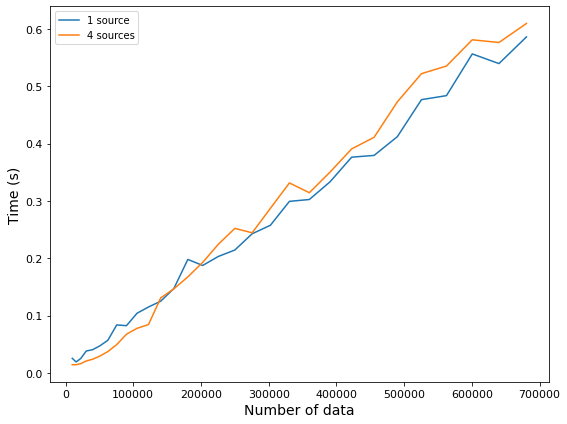

In [36]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_facecolor('xkcd:white')
plt.plot(time_sources['shapes'], time_sources['1source'], label='1 source')
plt.plot(time_sources['shapes'], time_sources['4source'], label='4 sources')
plt.ylabel('Time (s)', fontsize=14)
plt.xlabel('Number of data', fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(loc='best')
plt.tight_layout()
#plt.savefig('figures/time_sources_mag.png', dpi= 500)